In [1]:
from my_utils.dependencies import (
    pd, np, 
    plt, sns, 
    glob, tqdm, 
    timeit, textwrap, 
    sklearn, xgboost, 
    pytest, logging, 
    sys, stats, 
    zscore, curve_fit, 
    preprocessing, StandardScaler, 
    MinMaxScaler, LabelEncoder, 
    model_selection, train_test_split, 
    KFold, cross_val_score, 
    cross_val_predict, PCA, 
    TruncatedSVD, linear_model, 
    SGDClassifier, DecisionTreeRegressor, 
    SVR, LinearRegression, 
    KMeans, RandomForestRegressor, 
    Pipeline, make_pipeline, 
    metrics, classification_report, 
    confusion_matrix, accuracy_score, 
    mean_squared_error, mean_absolute_error, 
    r2_score, GridSearchCV, 
    warnings, logging
)

In [2]:
from my_utils.file_loading_utils import file_load, trim_raw_data

from my_utils.data_dict_utils import CreateDataDictionary

from my_utils.data_processing_utils import DatasetProcessor
from my_utils.data_grouper_utils import DataGrouper
from my_utils.feature_extraction_utils import FeatureExtraction

from my_utils.model_selection_utils import ModelSelection
from my_utils.model_trainer_utils import ModelTrainer

from my_utils.data_inspection_utils import DataInspection

In [3]:
sys.path.append('Advanced_Projects/Uber_Demand_Project/tests')
from tests import test_raw_data, test_processed_data

---

In [4]:
path = 'Uber_Demand_Project/data_archive/*.csv'
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

In [5]:
required_cols = ['Unnamed: 0',
                 'fare_amount', 
                 'pickup_datetime', 
                 'passenger_count'
                 ]

expected_raw_dtypes = ['int64',
                       'float64',
                       'datetime64[ns]',
                       'int64'
                       ]

expected_processed_dtypes = ['int64',
                             'float64',
                             'datetime64[ns]',
                             'int64',
                             'int64',
                             'object',
                             'object',
                             'int64'
                             ]

eng_feature_cols = ['fare_amount_pct_change',
                    'passenger_count_pct_change', 
                    'passenger_count_pct_change_sma',
                    'fare_amount_pct_change_sma'
                    ]

col_group = ['pickup_datetime',
             'fare_amount', 
             'passenger_count',
             'Label_Date'
             ]
 
col_feature = ['fare_amount', 
               'passenger_count'
               ]

file_n = 0
df_frac = 0.01
threshold = 0.05

group_by = 'hour'
n_window = 3

target_column = ['sPED']
cv_splits = 5
test_split = 0.1

---

# **Initial Exploration**

In [6]:
def data_dict_raw_pipeline(df, expected_dtypes):
    """
    Generates a data dictionary for a raw data set.

    Parameters:
    df (pandas.DataFrame): the raw data set
    expected_dtypes (list): a list of expected data types for each column in the data set

    Returns:
    pandas.DataFrame: the data dictionary for the raw data set
    """
    # create data dictionary object and make the data dictionary
    dd = CreateDataDictionary(df)
    df_dd = dd.make_my_data_dictionary(df)
    # transpose the data dictionary
    df_dd = df_dd.transpose()
    # add expected data types to the data dictionary
    df_dd['Expected_Type'] = expected_dtypes
    # save the data dictionary to a CSV file
    df_dd_save = df_dd.to_csv('Data_dict_raw.csv')
    # read the data dictionary from the CSV file and return it
    data_dict = pd.read_csv('Data_dict_raw.csv')
    return data_dict

def data_dict_processed_pipeline(df, expected_processed_dtypes):
    """
    Generates a data dictionary for a processed data set.

    Parameters:
    df (pandas.DataFrame): the processed data set
    expected_processed_dtypes (list): a list of expected data types for each column in the data set

    Returns:
    pandas.DataFrame: the data dictionary for the processed data set
    """
    # create data dictionary object and make the data dictionary
    dd = CreateDataDictionary(df)
    df_dd = dd.make_my_data_dictionary(df)
    # transpose the data dictionary
    df_dd = df_dd.transpose()
    # add expected data types to the data dictionary
    df_dd['Expected_Type'] = expected_processed_dtypes
    # save the data dictionary to a CSV file
    df_dd_save = df_dd.to_csv('Data_dict_processed.csv')
    # read the data dictionary from the CSV file and return it
    data_dict = pd.read_csv('Data_dict_processed.csv')
    return data_dict

---

In [7]:
def load_data(path, required_cols, df_frac, file_n, expected_raw_dtypes):
    """
    Load the data from given path, trim the data to include required columns and data fraction, and create a raw data 
    dictionary with expected data types for each column.

    Args:
    - path (str): file path for the data files.
    - required_cols (list): list of columns that must be included in the data.
    - df_frac (float): fraction of the data to be used for analysis.
    - file_n (int): the index of the file to be loaded from input_files.
    - expected_raw_dtypes (dict): dictionary containing the expected data types for each column.

    Returns:
    - df (pandas dataframe): dataframe containing the trimmed data.
    - df0 (pandas dataframe): dataframe containing the untrimmed data.
    - data_dict_raw (pandas dataframe): dataframe containing the raw data dictionary.
    """
    # Load data from the given path
    logging.info('Loading Data...')
    input_files = glob.glob(path)
    df = file_load(input_files)[file_n]
    df0 = file_load(input_files)[file_n]

    # Trim the data to include required columns and data fraction
    df = trim_raw_data(df, required_cols, df_frac)

    # Create a raw data dictionary with expected data types for each column
    data_dict_raw = data_dict_raw_pipeline(df, expected_raw_dtypes)
    
    return df, df0, data_dict_raw

In [8]:
def process_raw_data(data, threshold):
    """Process raw data by transforming it and removing outliers.

    Args:
    data (pd.DataFrame): The raw data to be processed.
    threshold (float): The value above which data points are considered outliers.

    Returns:
    pd.DataFrame: The processed data.

    """
    
    logging.info('Processing Raw Data...')

    # Initialize a DatasetProcessor object
    dataset = DatasetProcessor(data, threshold)

    # Transform the data
    data = dataset.data_transform()

    # Remove outliers from the data
    data = dataset.data_remove_outliers() 

    return data

In [9]:
def group_processed_data(data, col_group, group_by):
    """
    Group the processed data by hour or by day based on the group_by parameter.
    
    Args:
    data: A pandas dataframe with the processed data.
    col_group (str): The name of the column in the data to group by.
    group_by (str): The name of the time unit to group the data by. Can be either 'hour' or 'day'.
    
    Returns:
    A pandas dataframe with the grouped data.
    """
    
    logging.info('Grouping Processed Data...')
    group_class = DataGrouper(data, col_group)
    if group_by == 'hour':
        data = group_class.group_by_hour(col_group)
    elif group_by == 'day':
        data = group_class.group_by_day(col_group)
    return data

In [10]:
def feature_extraction(data, col_feature, n_window, expected_processed_dtypes):
    """
    Extracts features from the given DataFrame.

    Args:
    data (pd.DataFrame): The input DataFrame.
    col_feature (str): The feature column.
    n_window (int): The size of the window to calculate the Simple Moving Average (SMA) over.
    expected_processed_dtypes (dict): The expected data types of the processed DataFrame.

    Returns:
    tuple: A tuple containing the processed DataFrame and its data dictionary.
    """
    
    # Log the start of the function
    logging.info('Performing Feature Extraction...')
    
    # Instantiate the FeatureExtraction class
    feature_extraction = FeatureExtraction(data, col_feature, n_window)
    
    # Perform calculations to extract features
    data = feature_extraction.calc_pct_change(col_feature)
    data = feature_extraction.calc_sma('passenger_count_pct_change', n_window)
    data = feature_extraction.calc_sma('fare_amount_pct_change', n_window)
    data = feature_extraction.calc_sma_PED()
    
    # Generate data dictionary for processed data
    data_dict_pro = data_dict_processed_pipeline(data, expected_processed_dtypes)
    
    # Return extracted features and data dictionary
    return data, data_dict_pro

In [11]:
def further_data_cleaning(data, threshold):
    """
    Perform further data cleaning on a given dataset, including data cleaning, index setting and winsorization.
    
    Args:
    data (pandas.DataFrame): The dataset to be cleaned.
    threshold (float): The value above which to winsorize the data.
    
    Returns:
    pandas.DataFrame: The cleaned dataset.
    """
    logging.info('Performing further Cleaning...')
    dataset = DatasetProcessor(data, threshold)
    data = dataset.data_clean()
    data = dataset.index_set()
    data = dataset.winsorization()
    return data

In [12]:
def model_selection(data, target_column, cv_splits, test_split):
    
    logging.info('Initiating Model Selection Process...')
    model_select = ModelSelection(data, target_column, cv_splits, test_split)
    X_train, X_test, y_train, y_test = model_select.split_dataset()
    compare_models = model_select.run_model_evaluation()
    selected_model = model_select.select_initial_model()
    
    return compare_models, selected_model, X_train, X_test, y_train, y_test

In [13]:
def train_test_model(data, X_train, y_train, selected_model, cv_splits): 
    
    logging.info('Performing Model Training...')
    model = ModelTrainer(data, X_train, y_train, selected_model, cv_splits)
    train = model.train_model()
    cv_train = model.cv_predict()
    cv_train_2 = model.cv_score()

    logging.info('Performing Model Validation and Testing...')
    validation = model.validate_model(X_test, y_test)
    y_pred = model.test_model(X_test, y_test)
    visualise = model.visualize_results(X_test, y_test, y_pred)
    metrics = model.initial_model_metrics(X_test, y_test, y_pred)
    return metrics

In [14]:
def run_pipeline(path, required_cols, df_frac, file_n, expected_raw_dtypes,
                 threshold,
                 col_group,
                 col_feature, n_window, expected_processed_dtypes,
                 target_column, cv_splits, test_split):

    df, df0, data_dict_raw = load_data(path, required_cols, df_frac, file_n, expected_raw_dtypes)
    
    pytest.main(['-q', '-p', 'no:warnings', '--tb=no', 'tests/test_raw_data.py'])
    
    data = process_raw_data(df, threshold)
    data = group_processed_data(data, col_group, group_by)
    
    data, data_dict_pro = feature_extraction(data, col_feature, n_window, expected_processed_dtypes)
    
    data = further_data_cleaning(data, threshold)
    
    pytest.main(['-q', '-p', 'no:warnings', '--tb=no', 'tests/test_processed_data.py'])
    
    compare_models, selected_model, X_train, X_test, y_train, y_test = model_selection(data, target_column, cv_splits, test_split)

    # data = train_test_model(data, X_train, y_train, selected_model, cv_splits)
    
    # return data, X_train, y_train, X_test, y_test, selected_model

    
    pipeline_results = {
    "data": data,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
    "selected_model": selected_model
    }

    return pipeline_results

In [15]:
processing_pipeline = run_pipeline(path, required_cols, df_frac, file_n, expected_raw_dtypes,
                                   threshold,
                                   col_group,
                                   col_feature, n_window, expected_processed_dtypes,
                                   target_column, cv_splits, test_split)

2023-04-25 14:51:09,206 INFO: Loading Data...


C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive\uber.csv
Total number of files loaded: 1
C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive\uber.csv
Total number of files loaded: 1
.FF.F                                                                    [100%]

2023-04-25 14:51:14,134 INFO: Processing Raw Data...



=========================== short test summary info ===========================
FAILED tests/test_raw_data.py::test_missing_values - AssertionError: Datafram...
FAILED tests/test_raw_data.py::test_nan_values - ValueError: The truth value ...
FAILED tests/test_raw_data.py::test_data_types - AssertionError: Unexpected d...
3 failed, 2 passed in 3.12s


2023-04-25 14:51:14,457 INFO: Grouping Processed Data...
2023-04-25 14:51:14,468 INFO: Performing Feature Extraction...
2023-04-25 14:51:14,503 INFO: Performing further Cleaning...


.....                                                                    [100%]

2023-04-25 14:52:58,394 INFO: Initiating Model Selection Process...



5 passed in 103.50s (0:01:43)


Selected model: RandomForestRegressor
Hyperparameters: {'max_depth': 15, 'n_estimators': 100}
Model score: 0.827102364250835




In [16]:
data = processing_pipeline['data']
X_train = processing_pipeline['X_train']
y_train = processing_pipeline['y_train']
X_test = processing_pipeline['X_test']
y_test = processing_pipeline['y_test']
selected_model = processing_pipeline['selected_model']

# data, X_train, y_train, X_test, y_test, selected_model = processing_pipeline

2023-04-25 14:53:15,116 INFO: Performing Model Training...
2023-04-25 14:53:20,924 INFO: Performing Model Validation and Testing...
2023-04-25 14:53:20,977 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-04-25 14:53:20,988 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


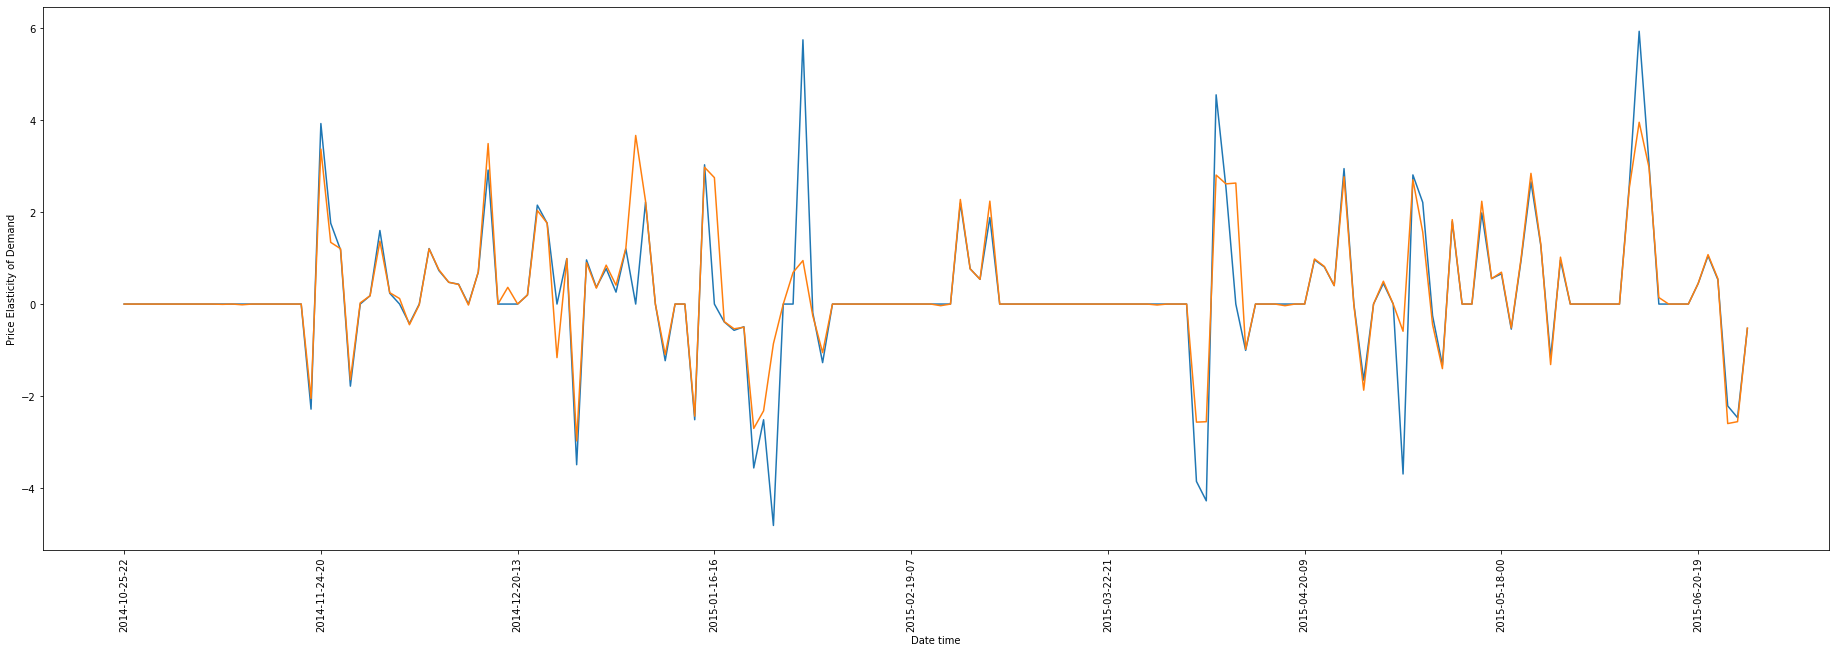

{'Initial_Model': RandomForestRegressor(max_depth=15),
 'Mean R^2': 0.7386379306711128,
 'Mean MAE': 0.23338777573888145,
 'Mean RMSE': 0.7482104619489959}

In [17]:
train_test_model(data, X_train, y_train, selected_model, cv_splits)